# Classifying stars and galaxies using machine learning

Authored by Maksim Nikiforov

NCSU ST590, Project 3

Spring, 2022

In [1]:
# Import required libraries and set up Spark session

# import os
# import sys
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import matplotlib.pyplot as plt
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/30 19:53:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/30 19:53:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Introduction

Since 2000, the [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org/) has cataloged hundreds of parameters for millions of celestial objects and has inspired nearly 11,000 peer-reviewed publications, making it "one of the most successful surveys in the history of astronomy"   <cite id="2qy3z"><a href="#zotero|6578788/Z75D4M6Y">(<i>Sloan Digital Sky Surveys | SDSS</i>, n.d.)</a></cite>. This notebook investigates a subset of the survey data. The intent of this exercise is to perform binary classification of photometric data using supervised learning, classifying observations from the Sloan Digital Sky Survey as either "stars" or "galaxies".   

The sections that follow introduce the Sloan Digital Sky Survey Data Release 7 and outline steps to retrieve its photometric data. [Section 2](#supervised_learning) provides a brief overview of supervised learning and its applicability in astronomy. This section also splits the photometric data into training and test sets in preparation for supervised model development. [Section 3](#eda) explores the training data in-depth. [Section 4](#modeling) introduces a variety of supervised learning algorithms and trains models using historic observations. These models are then applied to test data to evaluate how well they generalize with unseen objects. [Section 5](#conclusion) concludes the notebook with remarks about the findings of this exercise.         

## Data source and description

The data in this notebook is retrieved by querying the [CasJobs](https://skyserver.sdss.org/CasJobs/default.aspx) workbench for Data Release 7 (DR7), the seventh major data release from the Sloan Digital Sky Survey, with the SQL query below. Access to CasJobs is available to registered users of the [SciServer](https://www.sciserver.org/) online science platform. The query is credited to Vasconcellos et al., whose paper provides domain expertise for selecting features that "are known or expected to strongly correlate with the object classification" <cite id="41heo"><a href="#zotero|6578788/UXVJ3YSM">(Vasconcellos et al., 2011)</a></cite>.

```
 SELECT

    p.objID, p.ra, p.dec, s.specObjID,
    p.psfMag_r, p.modelMag_r, p.petroMag_r,
    p.fiberMag_r, p.petroRad_r, p.petroR50_r,
    p.petroR90_r, p.lnLStar_r,p.lnLExp_r,
    p.lnLDeV_r, p.mE1_r, p.mE2_r, p.mRrCc_r,
    p.type_r,p.type, s.specClass

 FROM PhotoObj AS p

    JOIN SpecObj AS s ON s.bestobjid = p.objid

 WHERE

    p.modelMag_r BETWEEN 14.0 AND 21.0

```

This SQL request retrieves 1,030,220 rows of observations with the following schema:

In [2]:
# Read CSV into a Spark DataFrame
sdss_data = spark.read.options(header="True", inferSchema="True", delimiter=",").csv(
    "sdss_cas_photometric_data.csv"
)

# View number of observations in the full CSV
print("Number of observatons:", sdss_data.count())

Number of observatons: 1030220


In [3]:
# Print the columns and column types in the DataFrame
print("SDSS DR7 schema:")
sdss_data.printSchema()

SDSS DR7 schema:
root
 |-- objID: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- specObjID: long (nullable = true)
 |-- psfMag_r: double (nullable = true)
 |-- modelMag_r: double (nullable = true)
 |-- petroMag_r: double (nullable = true)
 |-- fiberMag_r: double (nullable = true)
 |-- petroRad_r: double (nullable = true)
 |-- petroR50_r: double (nullable = true)
 |-- petroR90_r: double (nullable = true)
 |-- lnLStar_r: double (nullable = true)
 |-- lnLExp_r: double (nullable = true)
 |-- lnLDeV_r: double (nullable = true)
 |-- mE1_r: double (nullable = true)
 |-- mE2_r: double (nullable = true)
 |-- mRrCc_r: double (nullable = true)
 |-- type_r: integer (nullable = true)
 |-- type: integer (nullable = true)
 |-- specClass: integer (nullable = true)



The table below describes these attributes.

<style type="text/css">
.tg  {border-collapse:collapse;border-color:#ccc;border-spacing:0;margin:0px auto;}
.tg td{background-color:#fff;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{background-color:#f0f0f0;border-color:#ccc;border-style:solid;border-width:1px;color:#333;
  font-family:Arial, sans-serif;font-size:14px;font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-btxf{background-color:#f9f9f9;border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-abip{background-color:#f9f9f9;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-dzk6{background-color:#f9f9f9;text-align:center;vertical-align:top}
@media screen and (max-width: 767px) {.tg {width: auto !important;}.tg col {width: auto !important;}.tg-wrap {overflow-x: auto;-webkit-overflow-scrolling: touch;margin: auto 0px;}}</style>
<div class="tg-wrap"><table class="tg">
<thead>
  <tr>
    <th class="tg-fymr">Feature</th>
    <th class="tg-7btt">CAS Variable</th>
    <th class="tg-7btt">Description<br></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-btxf">PSF magnitude</td>
    <td class="tg-abip">  psfMag</td>
    <td class="tg-btxf">For isolated stars, which are well-described by the point spread function (PSF), the optimal measure of the total flux is determined by fitting a PSF model to the object.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Fiber magnitude</td>
    <td class="tg-c3ow">  fiberMag</td>
    <td class="tg-0pky">The flux contained within the aperture of a spectroscopic fiber</td>
  </tr>
  <tr>
    <td class="tg-btxf">Petrosian magnitude</td>
    <td class="tg-abip">  petroMag</td>
    <td class="tg-btxf">A measure of galaxy flux within a circular aperture whose radius is defined by the shape of the azimuthally averaged light profile</td>
  </tr>
  <tr>
    <td class="tg-0pky">Model magnitude</td>
    <td class="tg-c3ow">  modelMag</td>
    <td class="tg-0pky">Magnitudes that result from fitting a deVaucouleurs profile or an exponential profile to the two-dimensional image of each object in each band</td>
  </tr>
  <tr>
    <td class="tg-btxf">Petrosian radius</td>
    <td class="tg-abip">  petroRad</td>
    <td class="tg-btxf">The radius at which the Petrosian ratio equals 0.2. </td>
  </tr>
  <tr>
    <td class="tg-0pky">Radius carrying 50% of Petrosian flux</td>
    <td class="tg-c3ow">  petroR50</td>
    <td class="tg-0pky">The radii containing 50% of the Petrosian flux for each band</td>
  </tr>
  <tr>
    <td class="tg-btxf">Radius carrying 90% of Petrosian flux</td>
    <td class="tg-abip">  petroR90</td>
    <td class="tg-btxf">The radii containing 90% of the Petrosian flux for each band</td>
  </tr>
  <tr>
    <td class="tg-0pky">Likelihood PSF</td>
    <td class="tg-c3ow">  lnLStar</td>
    <td class="tg-0pky">The probabilities of achieving the measured chi-squared for the PSF fits</td>
  </tr>
  <tr>
    <td class="tg-btxf">Likelihood exponential</td>
    <td class="tg-abip">  lnLExp</td>
    <td class="tg-btxf">the probabilities of achieving the measured chi-squared for the exponential fits</td>
  </tr>
  <tr>
    <td class="tg-0pky">Likelihood deVaucouleurs</td>
    <td class="tg-c3ow">  lnLDeV</td>
    <td class="tg-0pky">The probabilities of achieving the measured chi-squared for the deVaucouleurs fits</td>
  </tr>
  <tr>
    <td class="tg-btxf">Adaptive moments</td>
    <td class="tg-abip">  mRrCc, mE1, mE2</td>
    <td class="tg-btxf">A method of measuring object shapes. These moments are close to optimal for measuring the shapes of faint galaxies, and have been used for weak lensing studies.</td>
  </tr>
  <tr>
    <td class="tg-0pky">Spectroscopic classification</td>
    <td class="tg-c3ow">  specClass</td>
    <td class="tg-0pky">Indicates the best-matching spectroscopic template. SpecClass = 1 is associated some kind of star, SpecClass = 2 means galaxy, and SpecClass = 3 or 4 means quasar.</td>
  </tr>
  <tr>
    <td class="tg-dzk6" colspan="3"><span style="font-weight:bold">Table 1</span>:  Attributes from the Sloan Digital Sky Survey Data Release 7 that have been deemed useful in classifying objects as stars or galaxies. </td>
  </tr>
</tbody>
</table></div>

The columns `objID`, `ra`, and `dec` are included solely to identify objects and their relative positions, as shown below. These columns will not be used as features in the supervised learning models, but `objID` will be invoked to visually inspect misclassified objects.  

Text(0.5, 1.0, 'Positional distribution of a sample of galaxies and stars in the \nSloan Digital Sky Survey Data Release 7')

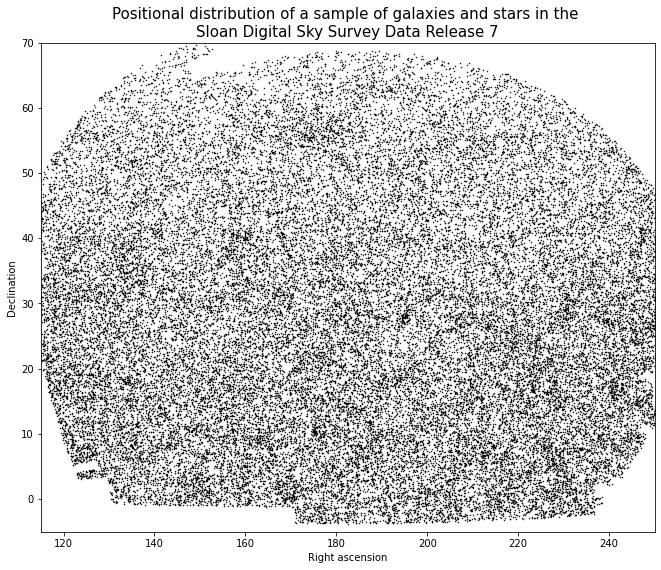

In [5]:
# Convert "ra", "dec" Spark DataFrame columns to
# pandas-on-spark and, subsequently, to pandas.
# Then, plot the positions of a sample of stars and galaxies.

# Converting to pandas allows us to bypass the 1,000-point limit that
# we enconter when plotting points from a pandas-on-spark DataFrame.

sdss_data[["ra", "dec"]].to_pandas_on_spark().to_pandas().sample(n=55000).plot.scatter(
    x="ra",
    y="dec",
    marker=".",
    color="black",
    s=1,
    figsize=(11, 9),
)

# Plot attributes - size, title, axes labels
plt.xlim(115, 250)
plt.ylim(-5, 70)
plt.xlabel("Right ascension")
plt.ylabel("Declination")
plt.title(
    "Positional distribution of a sample of galaxies and stars in the \nSloan Digital Sky Survey Data Release 7",
    fontsize=15,
)

A [schema browser](http://cas.sdss.org/dr7/en/help/browser/browser.asp) as well as a [Glossary of SDSS Terminology](http://classic.sdss.org/dr7/glossary/index.html) provide supplementary explanations for the remaining column in the data. These references show that, in the data sample below, rows in the integer-based `type` column equate to $3$ for "galaxies" and $6$ for "stars". The `SpecClass` column further subdivides observations into quasi-stellar objects (`specClass` = 3), blank-sky spectrums (`specClass` = 5), high-redshift quasars (`specClass` = 4), and unclassifiable spectrums (`specClass` = 0). These make up only a small number of observations, and the sections that follow will filter data to include only stars (`specClass` = 1) and galaxies (`specClass` = 2).   

In [4]:
# Temporarily convert to pandas-on-spark DataFrame for
# better appearance and print a sample of rows
sdss_data.to_pandas_on_spark().sample(frac=0.000009, random_state=375)

,objID,ra,dec,specObjID,psfMag_r,modelMag_r,petroMag_r,fiberMag_r,petroRad_r,petroR50_r,petroR90_r,lnLStar_r,lnLExp_r,lnLDeV_r,mE1_r,mE2_r,mRrCc_r,type_r,type,specClass
95055,588017626162856090,208.329531,42.143617,378810678128934912,19.66955,19.39850,19.33916,19.85486,1.808435,0.919265,2.647284,-87.031640,-34.843400,-17.418740,0.031619,0.001292,4.291618,3,3,3
299828,587725550657077467,118.643316,42.553861,123227341781467136,18.91117,17.63357,17.58065,18.87976,4.791534,2.167174,5.073331,-3391.407000,-152.015000,-155.313200,-0.488285,0.008607,25.881080,3,3,2
480801,587731680647381465,117.153197,28.628939,298307994662207488,20.89775,20.80967,20.81231,21.52881,3.297366,1.460478,2.915952,-0.032217,-0.068778,-0.059011,0.159274,-0.096245,13.104170,6,6,0
505840,587732577759723731,129.832462,4.016725,334618403597713408,20.17369,20.15578,20.19364,20.50568,1.199450,0.571036,1.372531,-0.577588,-0.481993,-0.482157,-0.048921,-0.127345,2.194953,6,6,1
552260,587734863758491768,157.341250,9.633242,348974100854603776,18.02336,17.71312,17.73007,18.24061,2.039186,0.968845,2.510408,-956.218300,-133.920000,-17.382880,-0.121592,0.108454,5.793008,3,3,2
619100,587734862148993203,160.098145,8.480134,349255462354419712,18.20551,17.10070,17.26290,18.28355,3.552720,1.665086,4.186486,-5690.805000,-194.754800,-79.564800,-0.181569,0.109649,15.890420,3,3,2
695576,587735349086126570,124.802560,8.053040,494779525561843712,18.03868,17.79789,17.83817,18.16190,1.200259,0.630797,1.321615,-1166.997000,-132.846600,-277.726200,0.151820,-0.035338,3.263561,3,6,1
890244,587739719214891153,189.003448,28.865667,629890713609306112,18.33371,17.68168,17.75912,18.47559,2.629342,1.246415,3.066203,-2139.585000,-100.493100,-6.951849,-0.060494,-0.032721,9.636144,3,3,2


<a id="supervised_learning"></a>
# Supervised learning

## Overview

When SDSS Data Release 7 became publicly available in 2008, it consisted of 15.7 TB of FITS image data, 18 TB of catalogs, and 26.8 TB of "other" data products <cite id="fb21r"><a href="#zotero|6578788/WRVILYFW">(<i>SDSS Data Release 7</i>, 2013)</a></cite>. Subsequent releases - DR8 through DR16 - swelled to 407 TB in volume, and the newest DR17 alone contains 245 TB of data <cite id="drr5l"><a href="#zotero|6578788/M4AXTGNR">(<i>Data Volume | SDSS</i>, 2021)</a></cite>. These size pale in comparison to the planned productivity of the Vera C. Rubin Observatory, which is expected to produce upwards of 500 petabytes of images and other data products <cite id="b20i6"><a href="#zotero|6578788/3B8U6ZL5">(<i>About Rubin Observatory | Rubin Observatory</i>, 2022)</a></cite>. Such vast pools of information are expected to require unsupervised and supervised learning to help automatically "locate, classify, and characterize objects" and to discover "new fundamental relationships between derived properties" <cite id="3wnhz"><a href="#zotero|6578788/LXV9B3I3">(Fluke &#38; Jacobs, 2020)</a></cite>.      

Supervised learning is the technique of using regression or classification algorithms and known variables ("predictors" or "features") to train models that predict numeric outputs or categorize observations based on probability. The act of "training" models involves using historical data, such as the SDSS DR7, to "find the relationship that has the best predictive power" for new observations <cite id="bkbzf"><a href="#zotero|6578788/ELIRRS3L">(Tatsat et al., 2020)</a></cite>. To avoid overfitting a model to training data, it is common practice to split historical data into "training" and "test" sets during model development. The training data is used to teach a model how to predict or classify an observation, while test data helps practitioners quantify model performance with unseen observations.  

## Data clean-up

Before splitting the sample DR7 data into train and test sets, it is prudent to investigate and resolve any missing values. Column- and subsequently row-wise summation indicates that there are nearly $12,000$ missing values in the data.  

In [11]:
# Count total number of missing values.
# "Missing" values include 0, -9999, NaN, and Null

# Solution is based on examples from
# https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/
# and
# https://stackoverflow.com/questions/53297872/how-can-i-sum-multiple-columns-in-a-spark-dataframe-in-pyspark

import pyspark.sql.functions as F

# Create a DataFrame with one row in which each column
# includes count of total missing values in that column
df_zero = sdss_data.select(
    [
        F.count(
            F.when(
                (sdss_data[c] == 0)
                | (sdss_data[c] == -9999)
                | (F.isnan(sdss_data[c]))
                | (sdss_data[c].isNull()),
                c,
            )
        ).alias(c)
        for c in sdss_data.columns
    ]
)

# Retrieve names of all columns
cols_list = df_zero.columns

# Parse an expression to sum the number of
# missing values across all rows
expression = "+".join(cols_list)

# Create a new column with the sum of missing values
# across all rows
df_sum = df_zero.withColumn("sum_missing", F.expr(expression))

# Display total number of missing values
df_sum.select("sum_missing").show()

+-----------+
|sum_missing|
+-----------+
|      11832|
+-----------+



Compared to the total number of rows in the data - $1,030,220$ - $11,832$ missing values is negligible. To avoid conflicts with functions in the Spark Machine Learning Library (MLlib), the values $-9999$ and $0$ can be converted to `None` and their associated rows may be removed. 

In [12]:
# Replace -9999 and 0 with "None"
sdss_data = sdss_data.replace(-9999, None)
sdss_data = sdss_data.replace(0, None)

In [6]:
# Remove rows with missing values and calculate new row count
sdss_data = sdss_data.dropna()
print("New row count, no missing values:\n", sdss_data.count())

New row count, no missing values:
 1030220


Removing rows with missing data leaves $1,030,220$ observations intact. These include objects where the spectrum is not classifiable (`specClass` = 0) or the spectrum is that of a quasi-stellar object (`specClass` = 3), a high-redshift quasar (`specClass` = 4), a blank sky (`specClass` = 5), or of another class of object. Since the goal of this activity is binary classification, the data will be filtered to include only stars (`specClass` = 1) and galaxies (`specClass` = 2), further reducing the dataset to $884,378$ objects.

In [10]:
# Filter DataFrame to include only the objects which are
# classified as either a "star" or a "galaxy".
# Print the new observation count.
sdss_data = sdss_data.filter((sdss_data.specClass == 1) | (sdss_data.specClass == 2))
print("Count of stars and galaxies only:\n", sdss_data.count())

Count of stars and galaxies only:
 884378


Lastly, a new column called `obj_category` can be created to translate the integer-based `type` column to a human-readable classification. 

In [23]:
from pyspark.sql.functions import col, when

# Create a rule to equate type=3 with "galaxy" and type=6 with "star"
conditions = when(col("type") == "6", "Star").when(col("type") == "3", "Galaxy")

# Apply the new rule to create a new column with
# human-readable classification labels
sdss_data = sdss_data.withColumn("obj_category", conditions)

# Retrieve a data subset with new column
sdss_data[["objID", "type", "obj_category"]].sample(fraction=0.000005, seed=4321).show()

+------------------+----+------------+
|             objID|type|obj_category|
+------------------+----+------------+
|587724232101658730|   3|      Galaxy|
|587727178985767024|   3|      Galaxy|
|587739827133546633|   3|      Galaxy|
|588016879360016724|   6|        Star|
|588011217526325453|   3|      Galaxy|
+------------------+----+------------+



## Data split - training and test sets

After purging missing values and filtering observations to only include stars and galaxies, 70% of the data may be set aside for training supervised models and 30% may be reserved for evaluating model performance. 

In [26]:
# 70/30 dataset split
train, test = sdss_data.randomSplit([0.7, 0.3])

<a id="eda"></a>
# Exploratory data analysis

After a 70/30 split, the training data contains $618,816$ observations. Nearly 562,000 are classified as galaxies, while the remaining 57,448 are classified as stars. 

In [36]:
# Categorize objects in the training data by their classification
# and obtain counts
train.groupBy("obj_category").count().show()

+------------+------+
|obj_category| count|
+------------+------+
|      Galaxy|561368|
|        Star| 57448|
+------------+------+



The distribution of magnitudes, `modelMag_r`, is unimodal and skewed left, with a peak in the range between $17.5-18$. 

Text(0.5, 1.0, 'Histogram of object magnitudes in the \nSDSS data sample')

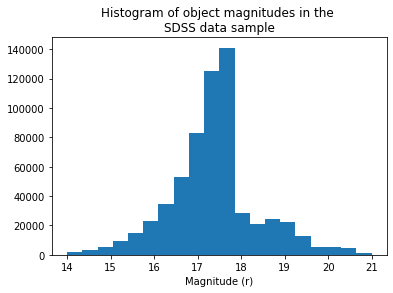

In [70]:
# Magnitude distribution
# Using matplotlib because of a known bug in which plotly
# does not display title, https://issues.apache.org/jira/browse/SPARK-37188
plt.hist(train.to_pandas_on_spark().modelMag_r, bins=20)
plt.xlabel("Magnitude (r)")
plt.title("Histogram of object magnitudes in the \nSDSS data sample")

Galaxies and stars have an average magnitude of 17.27 and 18.31, respectively. Since the magnitude scale is logarithmic, galaxies are approximately 2.6 times brighter than stars. 

In [48]:
# Obtain basic statistical summaries for object magnitudes
from pyspark.sql.functions import max, mean, min, stddev

train.groupby("obj_category").agg(
    mean("modelMag_r"), min("modelMag_r"), max("modelMag_r"), stddev("modelMag_r")
).show()

+------------+------------------+---------------+---------------+-----------------------+
|obj_category|   avg(modelMag_r)|min(modelMag_r)|max(modelMag_r)|stddev_samp(modelMag_r)|
+------------+------------------+---------------+---------------+-----------------------+
|      Galaxy| 17.27392723737376|       14.00007|       20.99957|     0.9133355573157584|
|        Star|18.306324001009614|       14.14085|        20.9992|     1.3840177436896288|
+------------+------------------+---------------+---------------+-----------------------+



In [72]:
# Calculate difference between psfMag and modelMag and create new column with results
train = train.withColumn("psfModelDiff", train.psfMag_r - train.modelMag_r)

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['obj_category']

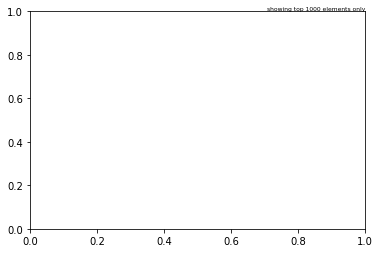

In [74]:
train.to_pandas_on_spark().plot.scatter(
    x="modelMag_r",
    y="psfModelDiff",
    color="obj_category",
    title="Difference between the point-spread function magnitude (psfMag) and <br>the model magnitude (modelMag) as a function of magnitude",
    labels=dict(modelMag_r="Magnitude (r)", psfModelDiff="psfMag-modelMag"),
)

<a id="modeling"></a>
# Modeling

## Set up transformations

In [195]:
from pyspark.ml.feature import SQLTransformer

sqlTrans = SQLTransformer(
    statement="SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        type FROM __THIS__"
)

In [196]:
lrSQLTrans = SQLTransformer(
    statement="SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        type FROM __THIS__"
)

In [197]:
# Create our list of features by dropping unused columns
# features_List = lrSQLTrans.transform(train).drop("type").columns
# features_List

In [198]:
features_List = train.select(
    [
        "psfMag_r",
        "modelMag_r",
        "petroMag_r",
        "fiberMag_r",
        "petroRad_r",
        "petroR50_r",
        "petroR90_r",
        "lnLStar_r",
        "lnLExp_r",
        "lnLDeV_r",
        "mE1_r",
        "mE2_r",
        "mRrCc_r",
    ]
).columns
features_List

['psfMag_r',
 'modelMag_r',
 'petroMag_r',
 'fiberMag_r',
 'petroRad_r',
 'petroR50_r',
 'petroR90_r',
 'lnLStar_r',
 'lnLExp_r',
 'lnLDeV_r',
 'mE1_r',
 'mE2_r',
 'mRrCc_r']

In [199]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

assembler = VectorAssembler(inputCols=features_list, outputCol="features")

# scaler = StandardScaler(inputCol="unscaledFeatures", outputCol="features")

## Logistic regression

In [201]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="type", outputCol="label", handleInvalid="skip")

In [202]:
from pyspark.ml.classification import LogisticRegression

In [203]:
lr = LogisticRegression()

The list of available logistic regression attributes in PySpark is available [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html#pyspark.ml.classification.LogisticRegression.aggregationDepth).

In [216]:
pipeline = Pipeline(stages=[stringIndexer, assembler, lr])

In [217]:
import numpy as np
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lrParamGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, np.arange(0, 0.1, 0.01))
    .addGrid(lr.elasticNetParam, [0, 1])
    .build()
)

lrCrossVal = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lrParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [218]:
lrCVModel = lrCrossVal.fit(train)

In [219]:
lrPredictions = lrCVModel.transform(test)

In [220]:
print("Accuracy:", MulticlassClassificationEvaluator().evaluate(lrPredictions))

Accuracy: 0.9944070358397437


In [221]:
from sklearn.metrics import confusion_matrix

y_pred = lrPredictions.select("prediction").collect()
y_orig = lrPredictions.select("label").collect()

lrCM = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(lrCM)

Confusion Matrix:
[[15336    64]
 [   32  1661]]


In [222]:
lrPredictions[["modelMag_r"]].describe().show()

+-------+------------------+
|summary|        modelMag_r|
+-------+------------------+
|  count|             17093|
|   mean|17.383792974316965|
| stddev|1.0114611344421824|
|    min|          14.00007|
|    max|          20.99957|
+-------+------------------+



In [224]:
lrPredictions.filter(lrPredictions.modelMag_r >= 20.5).count()

83

In [225]:
print(
    "Accuracy:",
    MulticlassClassificationEvaluator().evaluate(
        lrPredictions.filter(lrPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.8894724257300972


In [213]:
y_pred_faint = (
    lrPredictions.select("prediction").filter(lrPredictions.modelMag_r >= 19).collect()
)
y_orig_faint = (
    lrPredictions.select("label").filter(lrPredictions.modelMag_r >= 19).collect()
)

lrCM = confusion_matrix(y_orig_faint, y_pred_faint)
print("Confusion Matrix:")
print(lrCM)

Confusion Matrix:
[[692  33]
 [ 11 532]]


In [226]:
lrPredictions.show(1)

+------------------+------------+-----------+-----------------+--------+----------+----------+----------+----------+----------+----------+---------+---------+---------+--------+---------+--------+------+----+---------+-----+--------------------+--------------------+--------------------+----------+
|             objID|          ra|        dec|        specObjID|psfMag_r|modelMag_r|petroMag_r|fiberMag_r|petroRad_r|petroR50_r|petroR90_r|lnLStar_r| lnLExp_r| lnLDeV_r|   mE1_r|    mE2_r| mRrCc_r|type_r|type|specClass|label|            features|       rawPrediction|         probability|prediction|
+------------------+------------+-----------+-----------------+--------+----------+----------+----------+----------+----------+----------+---------+---------+---------+--------+---------+--------+------+----+---------+-----+--------------------+--------------------+--------------------+----------+
|587722952230175035|236.28687056|-0.51800318|96486454292643840|19.30703|  17.38941|  17.47781|  19.0598

In [229]:
lrPredictions.filter(
    (lrPredictions.modelMag_r >= 20.5)
    & (lrPredictions.label != lrPredictions.prediction)
).select(["objID", "label", "prediction"]).show(83)

+------------------+-----+----------+
|             objID|label|prediction|
+------------------+-----+----------+
|587724231569440810|  0.0|       1.0|
|587727179531747499|  0.0|       1.0|
|587725551727542930|  0.0|       1.0|
|587727214421934766|  1.0|       0.0|
|587727214952120523|  0.0|       1.0|
|587726014535893120|  0.0|       1.0|
|587726879411798207|  1.0|       0.0|
|587727226230931607|  1.0|       0.0|
|587729160574271708|  0.0|       1.0|
+------------------+-----+----------+



In [175]:
from IPython.core.display import HTML
from IPython.display import Image

Image(
    url="http://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra=197.99224324&dec=-1.17760226&scale=0.2&width=200&height=200&opt=G"
)

## Random forest classifier

In [144]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol="label", featuresCol="features")

Finally, we can set up a pipeline.

In [157]:
pipeline = Pipeline(stages=[sqlTrans, stringIndexer, assembler, rfc])

We can then set up cross-validation.

In [158]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rfcParamGrid = (
    ParamGridBuilder()
    .addGrid(rfc.maxDepth, [0, 10, 20, 30])
    .addGrid(rfc.numTrees, [5, 10, 20, 30, 40])
    .build()
)

crossVal = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rfcParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [159]:
# Run cross-validation, and choose the best set of parameters

cvModel = crossVal.fit(train)

In [160]:
rfcPredictions = cvModel.transform(test)

In [161]:
print("Accuracy:", MulticlassClassificationEvaluator().evaluate(rfcPredictions))

Accuracy: 0.9955029754735225


In [162]:
from sklearn.metrics import confusion_matrix

y_pred = rfcPredictions.select("prediction").collect()
y_orig = rfcPredictions.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[15383    32]
 [   45  1691]]


In [164]:
print(
    "Accuracy:",
    MulticlassClassificationEvaluator().evaluate(
        rfcPredictions.filter(rfcPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.878144843662085


In [168]:
rfcPredictions.filter(rfcPredictions.modelMag_r >= 20.5).select(
    ["label", "prediction"]
).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [169]:
rfcPredictions.show(1)

+--------+----------+----------+----------+----------+----------+----------+---------+---------+--------+----------+---------+--------+----+-----+--------------------+-------------+-----------+----------+
|psfMag_r|modelMag_r|petroMag_r|fiberMag_r|petroRad_r|petroR50_r|petroR90_r|lnLStar_r| lnLExp_r|lnLDeV_r|     mE1_r|    mE2_r| mRrCc_r|type|label|            features|rawPrediction|probability|prediction|
+--------+----------+----------+----------+----------+----------+----------+---------+---------+--------+----------+---------+--------+----+-----+--------------------+-------------+-----------+----------+
|19.13188|  17.86522|  18.05608|  19.05296|  3.351786|  1.572832|  4.143844|-2289.963|-52.85973|-33.3999|0.09548919|0.2916833|13.83563|   3|  0.0|[19.13188,17.8652...|   [30.0,0.0]|  [1.0,0.0]|       0.0|
+--------+----------+----------+----------+----------+----------+----------+---------+---------+--------+----------+---------+--------+----+-----+--------------------+-------------

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.9951260086324447


In [60]:
faint_mag = pred.filter((pred.modelMag_r >= 20.5) & (pred.modelMag_r <= 21))

In [61]:
acc_faint = evaluator.evaluate(faint_mag)
print("Prediction Accuracy: ", acc_faint)

Prediction Accuracy:  0.9223043524303716


In [9]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="prediction",
    metricName="areaUnderROC",
)

accuracy = evaluator.evaluate(pred)
print(f"Area under ROC = {accuracy} ")

NameError: name 'pred' is not defined

## Decision tree

In [61]:
from pyspark.ml.classification import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()

dtPipeline = Pipeline().setStages([sqlTrans, assembler, dtClassifier])

In [62]:
dtParamGrid = ParamGridBuilder().addGrid(dtClassifier.maxDepth, [0, 5, 10, 20]).build()

dtCrossVal = CrossValidator(
    estimator=dtPipeline,
    estimatorParamMaps=dtParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [63]:
# Run cross-validation, and choose the best set of parameters

dtCVModel = dtCrossVal.fit(train)

In [64]:
dtPredictions = dtCVModel.transform(test)

In [65]:
print("Accuracy:", MulticlassClassificationEvaluator().evaluate(dtPredictions))

Accuracy: 0.9937226278921604


## Gradient-boosted trees

In [81]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="type", outputCol="label", handleInvalid="skip")

gbtSQLTrans = SQLTransformer(
    statement="SELECT psfMag_r, modelMag_r, petroMag_r, fiberMag_r, \
                        petroRad_r, petroR50_r, petroR90_r, lnLStar_r, \
                        lnLExp_r, lnLDeV_r, mE1_r, mE2_r, mRrCc_r, \
                        label FROM __THIS__"
)

gbtClassifier = GBTClassifier()

gbtPipeline = Pipeline().setStages([stringIndexer, gbtSQLTrans, assembler, gbt])

In [82]:
gbtParamGrid = (
    ParamGridBuilder().addGrid(gbtClassifier.maxDepth, [0, 5, 10, 20]).build()
)

gbtCrossVal = CrossValidator(
    estimator=gbtPipeline,
    estimatorParamMaps=gbtParamGrid,
    evaluator=MulticlassClassificationEvaluator(),
    numFolds=3,
)

In [83]:
gbtCVModel = gbtCrossVal.fit(train)

In [84]:
gbtPredictions = gbtCVModel.transform(test)

In [88]:
gbtPredictions.show(5)

+--------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+-----------+--------+-----+--------------------+--------------------+--------------------+----------+
|psfMag_r|modelMag_r|petroMag_r|fiberMag_r|petroRad_r|petroR50_r|petroR90_r|lnLStar_r|  lnLExp_r|  lnLDeV_r|     mE1_r|      mE2_r| mRrCc_r|label|            features|       rawPrediction|         probability|prediction|
+--------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+-----------+--------+-----+--------------------+--------------------+--------------------+----------+
|18.70511|  16.89667|  16.91058|  18.57298|  5.902012|  2.750115|  5.684737|-11593.78| -422.4577| -1034.826| -0.305131| -0.1242297|51.97928|  0.0|[18.70511,16.8966...|[1.54261756354760...|[0.95627958330078...|       0.0|
|17.40547|  17.36561|  17.40621|  17.73569|  1.428235| 0.7082859|  1.609841|-26.98189|-0.8260614|-0.5565038|-0.16663

In [89]:
print(
    "Accuracy:",
    MulticlassClassificationEvaluator().evaluate(
        gbtPredictions.filter(gbtPredictions.modelMag_r >= 20.5)
    ),
)

Accuracy: 0.8769166317553414


In [95]:
gbtPredictions.filter(gbtPredictions.modelMag_r >= 20.5).select(
    gbtPredictions.label, gbtPredictions.prediction
).show(105)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  0.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|     

<a id="conclusion"></a>
# Conclusion

# References

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|6578788/3B8U6ZL5"></i><i>About Rubin Observatory | Rubin Observatory</i>. (2022). Vera C. Rubin Observatory. <a href="https://www.lsst.org/about">https://www.lsst.org/about</a></div>
  <div class="csl-entry"><i id="zotero|6578788/M4AXTGNR"></i><i>Data Volume | SDSS</i>. (2021). Sloan Digital Sky Survey. <a href="https://www.sdss.org/dr17/data_access/volume">https://www.sdss.org/dr17/data_access/volume</a></div>
  <div class="csl-entry"><i id="zotero|6578788/LXV9B3I3"></i>Fluke, C. J., &#38; Jacobs, C. (2020). Surveying the reach and maturity of machine learning and artificial intelligence in astronomy. <i>WIREs Data Mining and Knowledge Discovery</i>, <i>10</i>(2), e1349. <a href="https://doi.org/10.1002/widm.1349">https://doi.org/10.1002/widm.1349</a></div>
  <div class="csl-entry"><i id="zotero|6578788/WRVILYFW"></i><i>SDSS Data Release 7</i>. (2013). Sloan Digital Sky Survey. <a href="http://classic.sdss.org/dr7/">http://classic.sdss.org/dr7/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/Z75D4M6Y"></i><i>Sloan Digital Sky Surveys | SDSS</i>. (n.d.). Retrieved April 28, 2022, from <a href="https://www.sdss.org/surveys/">https://www.sdss.org/surveys/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/ELIRRS3L"></i>Tatsat, H., Puri, S., &#38; Lookabaugh, B. (2020). Machine Learning and Data Science Blueprints for Finance. In <i>Machine Learning and Data Science Blueprints for Finance</i>. O’Reilly Media. <a href="https://learning.oreilly.com/library/view/machine-learning-and/9781492073048/">https://learning.oreilly.com/library/view/machine-learning-and/9781492073048/</a></div>
  <div class="csl-entry"><i id="zotero|6578788/UXVJ3YSM"></i>Vasconcellos, E. C., Carvalho, R. R. de, Gal, R. R., LaBarbera, F. L., Capelato, H. V., Velho, H. F. C., Trevisan, M., &#38; Ruiz, R. S. R. (2011). DECISION TREE CLASSIFIERS FOR STAR/GALAXY SEPARATION. <i>The Astronomical Journal</i>, <i>141</i>(6), 189. <a href="https://doi.org/10.1088/0004-6256/141/6/189">https://doi.org/10.1088/0004-6256/141/6/189</a></div>
</div>
<!-- BIBLIOGRAPHY END -->